# Hamiltonian Evolution for a Water Molecule

This tutorial demonstrates the ability of the Classiq synthesis engine to reduce depth and cx-counts in approximated quantum functions for Hamiltonian evolution, focusing on Suzuki-Trotter (ST) and qDRIFT (qD) product formulas and their controlled operations. In addition, it is compared to the equivalent quantum examples in Qiskit.

The demonstration is for the Hamiltonian of a water molecule, which has 551 terms and a dimension of 12 qubits.

Define a molecule and get the Hamiltonian as a list of Pauli strings and coefficients:

In [1]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

from classiq.applications.chemistry.mapping import FermionToQubitMapper
from classiq.applications.chemistry.op_utils import qubit_op_to_pauli_terms
from classiq.applications.chemistry.problems import FermionHamiltonianProblem

molecule_H2O_geometry = [
    ("O", (0.0, 0.0, 0.0)),
    ("H", (0, 0.586, 0.757)),
    ("H", (0, 0.586, -0.757)),
]
molecule = MolecularData(molecule_H2O_geometry, "sto-3g", 1, 0)

molecule = run_pyscf(molecule)

problem = FermionHamiltonianProblem.from_molecule(molecule, first_active_index=1)
mapper = FermionToQubitMapper()
hamiltonian = qubit_op_to_pauli_terms(mapper.map(problem.fermion_hamiltonian))

These cases are examined:

In [2]:
ORDERS_for_ST = [1, 2, 4]
REPETITIONS_for_ST = [6, 4, 1]
N_QDS_for_qDRIFT = [1000, 2000]

In [3]:
classiq_depths = []
classiq_cx_counts = []

In [4]:
# transpilation_options = {"classiq": "custom", "qiskit": 3}
transpilation_options = {"classiq": "auto optimize", "qiskit": 1}

## 1. Approximating with Suzuki-Trotter formulas

In [5]:
from classiq import *

preferences = Preferences(
    custom_hardware_settings=CustomHardwareSettings(basis_gates=["cx", "u"]),
    transpilation_option=transpilation_options["classiq"],
)

all_qprogs = []

for k in range(len(ORDERS_for_ST)):

    @qfunc
    def main(qbv: Output[QArray]) -> None:
        allocate(hamiltonian.num_qubits, qbv)
        suzuki_trotter(
            pauli_operator=hamiltonian,
            evolution_coefficient=1,
            order=ORDERS_for_ST[k],
            repetitions=REPETITIONS_for_ST[k],
            qbv=qbv,
        )

    qprog = synthesize(main, preferences=preferences)
    all_qprogs.append(qprog)

    classiq_depths.append(qprog.transpiled_circuit.depth)
    classiq_cx_counts.append(qprog.transpiled_circuit.count_ops["cx"])

## 2. Implementing Controlled Hamiltonian Dynamics

In [6]:
for k in range(2):

    @qfunc
    def main(qbv: Output[QArray]) -> None:
        allocate(hamiltonian.num_qubits, qbv)
        ctrl = QBit()
        allocate(ctrl)
        control(
            ctrl=ctrl,
            stmt_block=lambda: suzuki_trotter(
                pauli_operator=hamiltonian,
                evolution_coefficient=1,
                order=ORDERS_for_ST[k],
                repetitions=REPETITIONS_for_ST[k],
                qbv=qbv,
            ),
        )

    qprog = synthesize(main, preferences=preferences)
    all_qprogs.append(qprog)

    classiq_depths.append(qprog.transpiled_circuit.depth)
    classiq_cx_counts.append(qprog.transpiled_circuit.count_ops["cx"])

## 3. Approximating with the qDRIFT Formula

In [7]:
def sparse_pauli_to_list(operator: SparsePauliOp) -> list[PauliTerm]:
    terms_list = []
    for term in operator.terms:
        pauli_list = [Pauli.I for i in range(operator.num_qubits)]
        for p in term.paulis:  # type:ignore[attr-defined]
            pauli_list[p.index] = p.pauli
        terms_list.append(
            PauliTerm(coefficient=term.coefficient, pauli=list(reversed(pauli_list)))
        )
    return terms_list

In [8]:
for n_qd in N_QDS_for_qDRIFT:

    @qfunc
    def main(qbv: Output[QArray]) -> None:
        allocate(hamiltonian.num_qubits, qbv)
        qdrift(
            pauli_operator=sparse_pauli_to_list(
                hamiltonian
            ),  # TODO replace with hamiltonian after a fix
            evolution_coefficient=1,
            num_qdrift=n_qd,
            qbv=qbv,
        )

    qprog = synthesize(main, preferences=preferences)
    all_qprogs.append(qprog)

    classiq_depths.append(qprog.transpiled_circuit.depth)
    classiq_cx_counts.append(qprog.transpiled_circuit.count_ops["cx"])

## 4. Comparing to Qiskit Implementation

Comments:
* Qiskit's Suzuki-Trotter of order 1 is a separate function, called the Lie-Trotter function.
* Qiskit's qDRIFT takes a long time to run for unclear problems. Alternatively, a random product formula is implemented, which is equivalent to qDRIFT.

The qiskit data was generated using qiskit version 1.0.0. To run the qiskit code uncomment the commented cells below.

In [9]:
qiskit_cx_counts = [25164, 33508, 41882, 186067, 248232, 3581, 7404]
qiskit_depths = [30627, 42879, 53581, 300924, 402125, 3463, 7141]

In [10]:
# from importlib.metadata import version
# try:
#     import qiskit
#     if version('qiskit') != "1.0.0":
#       !pip uninstall qiskit -y
#       !pip install qiskit==1.0.0
# except ImportError:
#     !pip install qiskit==1.0.0

In [11]:
# from qiskit.circuit.library import PauliEvolutionGate
# from qiskit.quantum_info import SparsePauliOp
# from qiskit.synthesis import LieTrotter as LieTrotter_qiskit

# qiskit_depths = []
# qiskit_cx_counts = []

# operator = SparsePauliOp.from_list(pauli_list)
# gate = PauliEvolutionGate(operator, 1)

In [12]:
# ## Suzuki-Trotter of order 1 = Lie-Trotter
# from qiskit import transpile

# lt = LieTrotter_qiskit(reps=REPETITIONS_for_ST[0])
# circ = lt.synthesize(gate)
# tqc = transpile(
#     circ, basis_gates=["u", "cx"], optimization_level=transpilation_options["qiskit"]
# )
# qiskit_depths.append(tqc.depth())
# qiskit_cx_counts.append(tqc.count_ops()["cx"])

In [13]:
# ## Suzuki-Trotter
# from qiskit.synthesis import SuzukiTrotter as SuzukiTrotter_qiskit

# for k in range(1, 3):
#     st = SuzukiTrotter_qiskit(order=ORDERS_for_ST[k], reps=REPETITIONS_for_ST[k])
#     circ = st.synthesize(gate)
#     tqc = transpile(
#         circ,
#         basis_gates=["u", "cx"],
#         optimization_level=transpilation_options["qiskit"],
#     )
#     qiskit_depths.append(tqc.depth())
#     qiskit_cx_counts.append(tqc.count_ops()["cx"])

In [14]:
# # Controlled dynamics
# lt_ctrl = LieTrotter_qiskit(reps=REPETITIONS_for_ST[0])
# circ = lt_ctrl.synthesize(gate).control(1)
# tqc = transpile(
#     circ, basis_gates=["u", "cx"], optimization_level=transpilation_options["qiskit"]
# )
# qiskit_depths.append(tqc.depth())
# qiskit_cx_counts.append(tqc.count_ops()["cx"])

# for k in range(1, 2):
#     st_ctrl = SuzukiTrotter_qiskit(order=ORDERS_for_ST[k], reps=REPETITIONS_for_ST[k])
#     circ = st_ctrl.synthesize(gate).control(1)
#     tqc = transpile(
#         circ,
#         basis_gates=["u", "cx"],
#         optimization_level=transpilation_options["qiskit"],
#     )
#     qiskit_depths.append(tqc.depth())
#     qiskit_cx_counts.append(tqc.count_ops()["cx"])

In [15]:
# ## For qDRIFT, generate a random sequence
# import numpy as np


# def index_channel(n, list_coe):
#     """
#     This function gets an ordered list of coefficients 'list_coe' and a number of calls 'n' as inputs.
#     It returns a random ordered list of size n with elements from list_coe',
#     where the probability of choosing the i-th elements is list_coe[i]/sum(list_coe),
#     """
#     coe = np.array(list_coe) / sum(list_coe)
#     c_coe = np.cumsum(coe)
#     return np.searchsorted(c_coe, np.random.uniform(size=n))


# assert (
#     pauli_list[0][0] == len(pauli_list[0][0]) * "I"
# ), """The Identity term is not the first on the list of Paulis,
# please modify the code accordingly """

# pauli_list_without_id = pauli_list[1::]
# po_coe = [
#     np.abs(np.real(p[1])) for p in pauli_list_without_id
# ]  # gets absolute value of coefficients

# for n_qd in N_QDS_for_qDRIFT:
#     new_indices = index_channel(n_qd, po_coe)
#     small_lambda = sum(po_coe)
#     randomly_generated_pauli_list = [
#         (
#             pauli_list_without_id[new_indices[k]][0],
#             np.sign(pauli_list_without_id[new_indices[k]][1]) * small_lambda / n_qd,
#         )
#         for k in range(n_qd)
#     ]
#     randomly_generated_pauli_list += [pauli_list[0]]  # adding the identity
#     gate_qd = PauliEvolutionGate(
#         SparsePauliOp.from_list(randomly_generated_pauli_list), 1
#     )
#     qd = LieTrotter_qiskit(reps=1)
#     circ = qd.synthesize(gate_qd)
#     tqc = transpile(
#         circ,
#         basis_gates=["u", "cx"],
#         optimization_level=transpilation_options["qiskit"],
#     )
#     qiskit_depths.append(tqc.depth())
#     qiskit_cx_counts.append(tqc.count_ops()["cx"])

## 5. Plotting the Data

In [16]:
print("The cx-counts on Classiq:", classiq_cx_counts)
print("The cx-counts on Qiskit:", qiskit_cx_counts)

The cx-counts on Classiq: [9402, 12458, 15570, 21252, 28270, 3388, 6712]
The cx-counts on Qiskit: [25164, 33508, 41882, 186067, 248232, 3581, 7404]


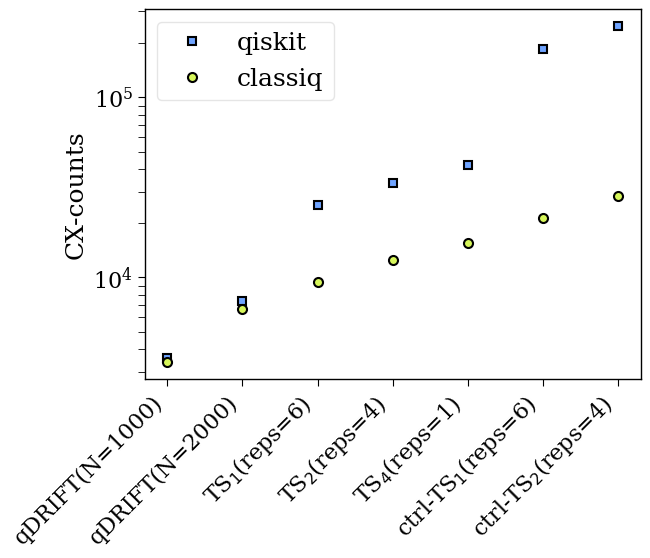

In [17]:
import matplotlib.pyplot as plt

classiq_color = "#D7F75B"
qiskit_color = "#6FA4FF"
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5

plt.semilogy(
    qiskit_cx_counts[-2::] + qiskit_cx_counts[0:5],
    "s",
    label="qiskit",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=6,
    markeredgewidth=1.5,
)
plt.semilogy(
    classiq_cx_counts[-2::] + classiq_cx_counts[0:5],
    "o",
    label="classiq",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=6.5,
    markeredgewidth=1.5,
)

labels = [
    "qDRIFT(N=1000)",
    "qDRIFT(N=2000)",
    "TS$_1$(reps=6)",
    "TS$_2$(reps=4)",
    "TS$_4$(reps=1)",
    "ctrl-TS$_1$(reps=6)",
    "ctrl-TS$_2$(reps=4)",
]
plt.xticks([0, 1, 2, 3, 4, 5, 6], labels, rotation=45, fontsize=16, ha="right")
plt.ylabel("CX-counts", fontsize=18)
plt.yticks(fontsize=16)
plt.legend(loc="upper left", fontsize=18, fancybox=True, framealpha=0.5)